#La medicina es cara
El coste de los seguros médicos varía bastante según las circunstancias de cada persona, pero a veces averiguar como se calcula realmente no es tan sencillo. A continuación con un cojuntos de datos, vamos a predecir como varia los cargos de seguro médico en fución de las características de un grupo de personas.

In [1]:
!pip install --user --upgrade apafib --quiet


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split,  KFold, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

from yellowbrick.regressor import AlphaSelection

from statsmodels.genmod.generalized_linear_model import GLM
import statsmodels.api as sm
from scipy import stats

Cargamos el conjuntos de datos *Medical Cost Personal Daset* que vamos a trabajar a partir de la librería apafib

In [3]:
from apafib import load_medical_costs

medical_costs_data = load_medical_costs()

# peak into the data
medical_costs_data.head()


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


##Apartado A
### División de los datos

Dividimos los datos en conjuntos de entrenamiento y test (70%/30%) con validación cruzada sobre la partición de entrenamiento para decidir los hiperparámetros.

In [4]:
from sklearn.model_selection import train_test_split

X = medical_costs_data.loc[:, medical_costs_data.columns != 'charges']
y = medical_costs_data['charges']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=33)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(936, 6) (936,)
(402, 6) (402,)


####Exploración del conjuntos de datos de entrenamiento

El primer paso es hacer una pequeña exploración del conjunto de datos de entrenamiento observando las relaciones entre las variables, especialmente con la variable objetivo.

In [5]:
medical_costs_data.describe(include='all')

,age,sex,bmi,children,smoker,region,charges
count,1338.000000,1338,1338.000000,1338.000000,1338,1338,1338.000000
unique,NaN,2,NaN,NaN,2,4,NaN
top,NaN,male,NaN,NaN,no,southeast,NaN
freq,NaN,676,NaN,NaN,1064,364,NaN
mean,39.207025,NaN,30.663397,1.094918,NaN,NaN,13270.422265
std,14.049960,NaN,6.098187,1.205493,NaN,NaN,12110.011237
min,18.000000,NaN,15.960000,0.000000,NaN,NaN,1121.873900
25%,27.000000,NaN,26.296250,0.000000,NaN,NaN,4740.287150
50%,39.000000,NaN,30.400000,1.000000,NaN,NaN,9382.033000
75%,51.000000,NaN,34.693750,2.000000,NaN,NaN,16639.912515


A primera vista podemos observar hay 7 atributos en total, en los cual tres de ellos són categóricos: *sex* , *smoker* y *region*, y restos numéricos: *age*, *bmi*, *children* y *charges*.

In [6]:
X_train.isna().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
dtype: int64

In [7]:
y_train.isna().sum()

0

No tenemos ningún NA en el conjunto de datos de entrenamiento.

En la tabla que aparece a continuación podemos observar las estadísticas descriptivas de la variable objetivo del conjunto de datos de entrenamiento.

In [8]:
y_train.describe(include='all')

count      936.000000
mean     13334.235091
std      12128.085711
min       1135.940700
25%       4739.692138
50%       9369.615750
75%      17096.057220
max      63770.428010
Name: charges, dtype: float64

#####Variables númericas
A continuación vamos a visualizar las variables númericas, primer de todo hay que generar un Dataframe con las variables numérical del conjunto de datos de entrenamiento


In [9]:
numerical_columns = ['age','bmi','children']
numerical_data = X_train[numerical_columns]
numerical_data.insert(3,'charges', y_train)


In [10]:
numerical_data.describe()


,age,bmi,children,charges
count,936.000000,936.000000,936.000000,936.000000
mean,38.957265,30.765545,1.089744,13334.235091
std,13.904883,6.120544,1.202698,12128.085711
min,18.000000,15.960000,0.000000,1135.940700
25%,27.000000,26.410000,0.000000,4739.692138
50%,39.000000,30.495000,1.000000,9369.615750
75%,51.000000,34.600000,2.000000,17096.057220
max,64.000000,52.580000,5.000000,63770.428010


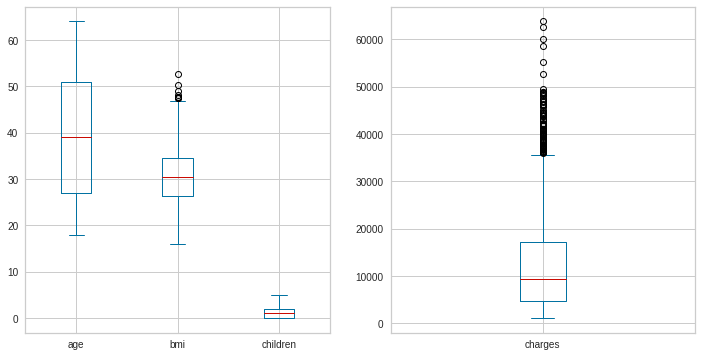

In [11]:
fig, ax = plt.subplots(1,2,figsize=(12,6));
X_train[numerical_columns].plot(kind='box',ax=ax[0])
y_train.plot(kind='box',ax=ax[1])

A través de los boxplots, vemos como la variabilidad de cada una de las variables es pequeña. Como podemos ver, los atributos *bmi* y *charges*, tienen valores atípicos. Aún así, hemos decidido dejarlos ya que podrían aportar información útil a la hora de definir los modelos.

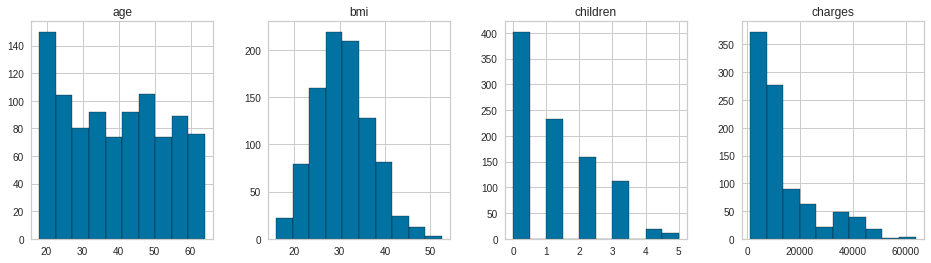

In [12]:
numerical_data.hist(figsize=(16,4), layout=(1,4),edgecolor='black');


Se puede ver como la mayoria de los personal tiene un bmi areledor de 28-33, la mayoria de ellos no tienen hijos, y con un cargo entre 0 - 14000.

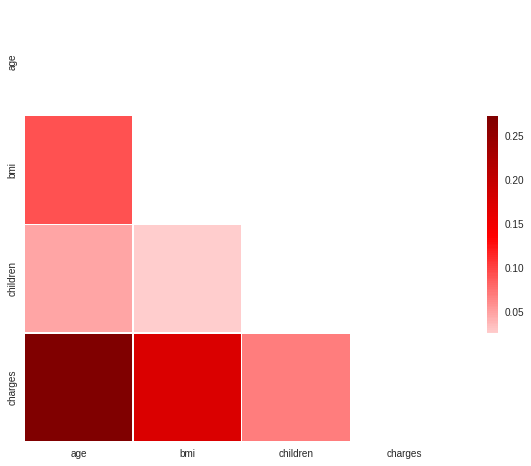

In [13]:
corr = numerical_data.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.subplots(figsize=(10, 8))
sns.heatmap(corr, mask=mask, cmap='seismic',  center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5});

En esta figura podemos ver la correlación entre los distintos atributos númericos. Como parece lógico la edad, tiene una alta correlación con la variable objetivo. Por otra parte, vemos como el parámetros bmi parece tener una significativa correlación con el cargo del seguro médico.

####Variables categóricas

In [14]:
categorical_columns = ['sex','smoker','region']
categorical_data = X_train[categorical_columns]
categorical_data.insert(3,'charges', y_train)
categorical_data

,sex,smoker,region,charges
618,female,yes,southeast,34439.85590
1206,female,no,southwest,36910.60803
217,male,no,southeast,2483.73600
647,female,no,northeast,8252.28430
297,male,yes,southeast,21978.67690
...,...,...,...,...
1225,female,no,southeast,4795.65680
658,female,no,northeast,26392.26029
578,male,no,southwest,9724.53000
391,female,no,northwest,2138.07070


male      477
female    459
Name: sex, dtype: int64


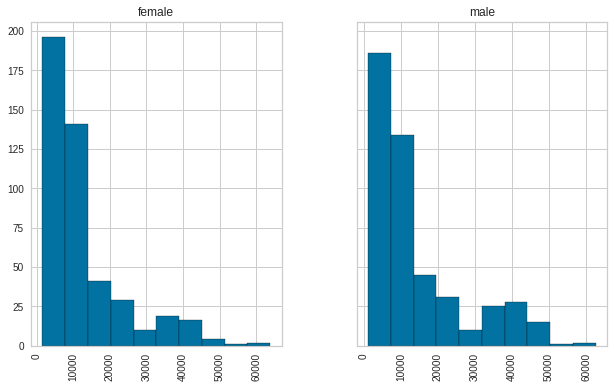

In [15]:
print(categorical_data['sex'].value_counts())
categorical_data.hist(column='charges',by='sex',bins=10, sharey=True, figsize=(10,6), edgecolor='black');

El histograma anterior, observamos que el variable objetivo esta forzamente balanceado en función de la variable sexo.

no     737
yes    199
Name: smoker, dtype: int64


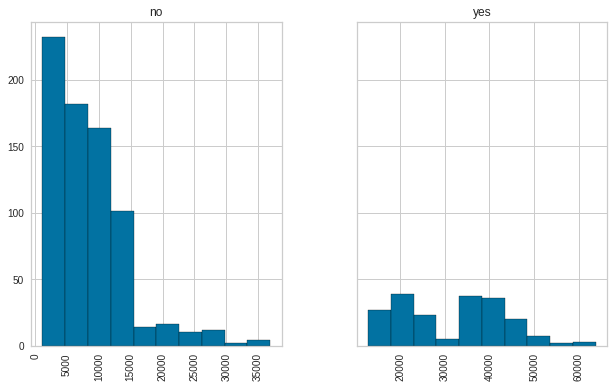

In [16]:
print(categorical_data['smoker'].value_counts())
categorical_data.hist(column='charges',by='smoker',bins=10, sharey=True, figsize=(10,6), edgecolor='black');

Vemos que la mayoria de cargos de seguros médicos són menores que 15000, y grande parte de ellos són comprados por los no fumadores.

southeast    256
northwest    240
southwest    221
northeast    219
Name: region, dtype: int64


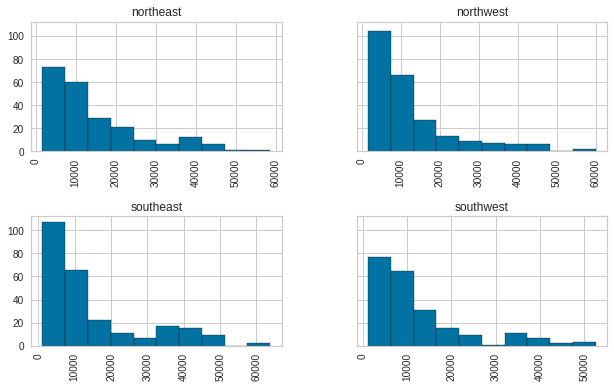

In [17]:
print(categorical_data['region'].value_counts())
categorical_data.hist(column='charges',by='region',bins=10, sharey=True, figsize=(10,6), edgecolor='black');

##Preprocessing

In [18]:
def minimum_preprocessing(X, y):
  # Convert categorical variables to numerical variables
  X['sex'] = X['sex'].replace(['female','male'],[0,1])
  X['smoker'] = X['smoker'].replace(['no','yes'],[0,1])
  X['region'] = X['region'].replace(['northeast','northwest', 'southeast', 'southwest'],[0,1,2,3])

  return X, y

Para poder aplicar el modelo de regresión de manera adecuada hemos tranformado todos los atributos categóricos a númericos tanto por los datos de entrenamiento como por el test.  Dónde la variable *sexo*: el 0 indica femenino y 1 masculino, variable *smoker*: 0 indica no fumador y 1 fumador, finalmente tenoemos *region* northeast, northwest, southeast y southwest respresentan 0,1,2,3 respectivamente.

In [19]:
X_train, y_train = minimum_preprocessing(X_train,y_train)
X_test, y_test = minimum_preprocessing(X_test,y_test)
print(X_train.head())
print(X_train.dtypes)

      age  sex    bmi  children  smoker  region
618    19    0  33.11         0       1       2
1206   59    0  34.80         2       0       3
217    27    1  23.10         0       0       2
647    40    0  23.37         3       0       0
297    47    1  25.41         1       1       2
age           int64
sex           int64
bmi         float64
children      int64
smoker        int64
region        int64
dtype: object


##Apartado B
### Regresión lineal
Utilizamos los modelos scikit-learn para la regresión lineal

In [20]:
# Instanciamos el modelo LinearRegression 
lr = LinearRegression();

# Ajustamos con los datos de entrenamiento con el método fit
lr.fit(X_train,y_train);

# Predecimos con el método predict 
y_pred = lr.predict(X_train);

In [21]:
weights = lr.coef_
intercept = lr.intercept_
# Podemos acceder a información del modelo, como los pesos.
print('Coeficientes: \n', weights[:10])
print('Interceptor: \n', intercept)

Coeficientes: 
 [  254.04009955  -395.49203031   340.03483754   518.71893976
 23821.49400757  -395.5110213 ]
Interceptor: 
 -11854.249122637566


####Calidad de regresión lineal del conjunto de datos de entrenamiento

Para medir el rendimiento de un modelo de regresión podemos utilizar las funciones de pérdidas, a continuación vamos a repasar las más comunes de ellas.


**Error medio cuadrático**, dónde si da 0 significaría una predicción perfecta, pero este número depende de la magnitud de la variable objetivo, por lo tanto no podemos saber si la calidad de la regresión es buena o no. 

In [22]:
mean_square_error_sk = mean_squared_error(y_train, y_pred)
print('MSE:',mean_square_error_sk)

MSE: 37437600.18431918


Podemos utilizar **MSE normalizado** para estimar la calidad, un modelo con norm_mse de 0.25 es bastante buenos

In [23]:
norm_mse_sk = 1-r2_score(y_train,y_pred)
print('NORM_MSE:',norm_mse_sk)

NORM_MSE: 0.25479313636080425


**R²** es la proporción de la varianza en la variable de respuesta que puede ser explicada por las variables predictoras. Dónde 1 indica que la variable de respuesta puede ser perfectamente explicada sin error por las variables predictoras, y 0 lo contrario. En este caso alcanza ~74.5%

In [24]:
R_squared_sk = r2_score(y_train,y_pred)
print('R^2:',R_squared_sk)

R^2: 0.7452068636391957


El mejor resultado posible también sería un **MAE** de 0, lo que significaría una predicción perfecta.

In [25]:
mae_sk = mean_absolute_error(y_train,y_pred)
print('MAE:',mae_sk)

MAE: 4221.4472300051175


####Calidad de regresión lineal utilizando validación cruzada


In [26]:
#Validación cruzada
cross_val_metrics = pd.DataFrame(columns=['MSE', 'norm_MSE', 'R2'])

kf = KFold(n_splits=5)
i=1
for train_index, test_index in kf.split(X_train):
    print('Split {}: \n\tTest Folds: [{}] \n\tTrain Folds {}'.format(i, i, [j for j in range(1,6) if j != i]));
    
    x_train_fold = X_train.values[train_index]
    y_train_fold = y_train.values[train_index]
    x_test_fold = X_train.values[test_index,:]
    y_test_fold = y_train.values[test_index]
    
    lr = LinearRegression().fit(x_train_fold,y_train_fold)
    y_pred_fold = lr.predict(x_test_fold)
    fold_mse =mean_squared_error(y_test_fold, y_pred_fold)
    fold_nmse =  1-r2_score(y_test_fold, y_pred_fold)
    fold_r2 = r2_score(y_test_fold, y_pred_fold)
    print(f'\tMSE: {fold_mse:3.3f} NMSE: {fold_nmse:3.3f} R2: {fold_r2:3.3f}')

    cross_val_metrics.loc[f'Fold {i}', :] = [fold_mse,fold_nmse, fold_r2]
    i+=1

Split 1: 
	Test Folds: [1] 
	Train Folds [2, 3, 4, 5]
	MSE: 32660433.387 NMSE: 0.320 R2: 0.680
Split 2: 
	Test Folds: [2] 
	Train Folds [1, 3, 4, 5]
	MSE: 47980473.672 NMSE: 0.346 R2: 0.654
Split 3: 
	Test Folds: [3] 
	Train Folds [1, 2, 4, 5]
	MSE: 32123916.123 NMSE: 0.193 R2: 0.807
Split 4: 
	Test Folds: [4] 
	Train Folds [1, 2, 3, 5]
	MSE: 38445654.845 NMSE: 0.253 R2: 0.747
Split 5: 
	Test Folds: [5] 
	Train Folds [1, 2, 3, 4]
	MSE: 40158815.686 NMSE: 0.236 R2: 0.764


In [27]:
cross_val_metrics.loc['Mean',:] = cross_val_metrics.mean()
cross_val_metrics

,MSE,norm_MSE,R2
Fold 1,32660433.387024,0.320381,0.679619
Fold 2,47980473.672411,0.346041,0.653959
Fold 3,32123916.122859,0.193326,0.806674
Fold 4,38445654.845172,0.253076,0.746924
Fold 5,40158815.685863,0.236433,0.763567
Mean,38273858.742666,0.269851,0.730149


  A partir de la media de los cinco folds podemos observar que la calidad es regularmente buena, ya que MSE normalizado es ~0.27 y R2 alcanza un ~73%.

In [28]:
lr = LinearRegression().fit(X_train,y_train);
folds_r2 = cross_val_score(lr, X_train,y_train, cv=5, scoring='r2')
lr_r2 = np.mean(folds_r2) 
folds_r2, lr_r2

(array([0.67961949, 0.65395914, 0.80667367, 0.74692353, 0.76356749]),
 0.7301486616209422)

##Residuos
Podemos obtener un gráfico de los residuos del entrenamiento y el test con el _qqplot_ o el _histograma_ con la librería `yellowbrick`

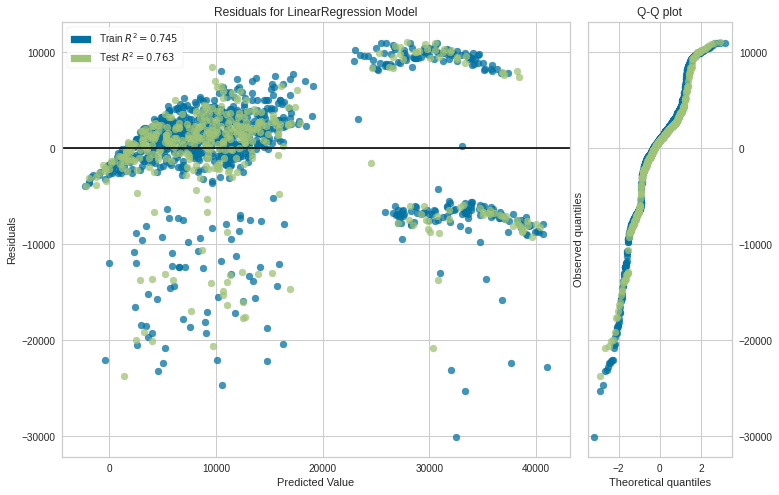

In [29]:
from yellowbrick.regressor import residuals_plot
plt.figure(figsize=(12,8));
viz = residuals_plot(lr, X_train, y_train, X_test, y_test, is_fitted=True, qqplot=True, hist=False);

A partir del plot anterior podemos observar que tiene puntos dispersos aleatoriamente alrededor del eje horizontal la mayoria se centraliza donde eje x tiene valor menor que 20.000. Observando el Q-Q plot podemos observar los residuos no estan distribuidos normalmente.

También podemos representar las predicciones respecto a los valores reales y ver cuanto se desvían de la predicción ideal

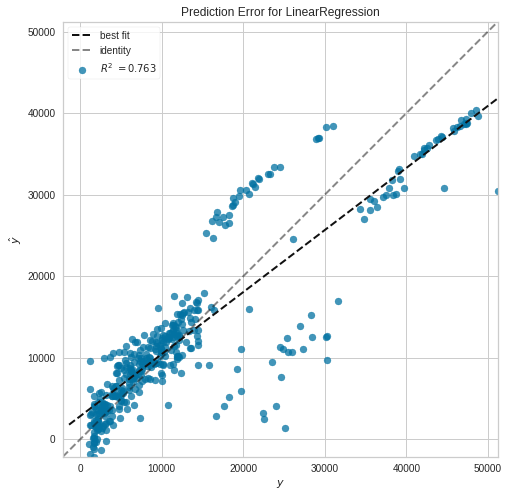

In [30]:
from yellowbrick.regressor import prediction_error

plt.figure(figsize=(8,8))
visualizer = prediction_error(lr, X_test, y_test, is_fitted=True)

##Apartado C
###PolynomialFeatures

In [31]:
poly = PolynomialFeatures(2)
X_train2 = poly.fit_transform(X_train)
y_train2 = y_train
X_test2 = poly.fit_transform(X_test)
y_test2 = y_test

print(X_train2.shape, y_train2.shape)
print(X_test2.shape, y_test2.shape)

(936, 28) (936,)
(402, 28) (402,)


##Apartado D
###Regresión lineal y regresión LASSO con nuevos datos

In [32]:
# Instanciamos el modelo LinearRegression 
lr2 = LinearRegression();

# Ajustamos con los datos de entrenamiento con el método fit
lr2.fit(X_train2,y_train2);

# Predecimos con el método predict 
y_pred2 = lr2.predict(X_train2);
X_train2.shape

(936, 28)

In [33]:
weights = lr2.coef_
intercept = lr2.intercept_
# Podemos acceder a información del modelo, como los pesos.
print('Coeficientes: \n', weights[:10])
print('Interceptor: \n', intercept)

Coeficientes: 
 [ 3.33778979e+14  2.90235432e+02 -5.67503929e+02  1.33641051e+03
  1.10943137e+03 -9.88887357e+03 -1.01846555e+03  8.68630157e-01
 -1.84076512e+01 -4.63072507e+00]
Interceptor: 
 -333778978748249.9


Acotinuación podéis visualizar la metricas del conjunto de datos

In [34]:
mean_square_error_sk2 = mean_squared_error(y_train2, y_pred2)
norm_mse_sk2 = 1-r2_score(y_train2,y_pred2)
R_squared_sk2 = r2_score(y_train2,y_pred2)
mae_sk2 = mean_absolute_error(y_train2,y_pred2)
print('MSE',mean_square_error_sk2)
print('NORM_MSE',norm_mse_sk2)
print('R^2',R_squared_sk2)
print('MAE',mae_sk2)

table = pd.DataFrame({"lr":[mean_square_error_sk,norm_mse_sk,R_squared_sk,mae_sk],
                     "lr_degree2":[mean_square_error_sk2,norm_mse_sk2,R_squared_sk2,mae_sk2]
                     }, index=['MSE', 'Norm_MSE', 'R^2', 'MAE'])

table


MSE 26457008.48217188
NORM_MSE 0.18006133236928157
R^2 0.8199386676307184
MAE 3413.8059315598293


,lr,lr_degree2
MSE,3.743760e+07,2.645701e+07
Norm_MSE,2.547931e-01,1.800613e-01
R^2,7.452069e-01,8.199387e-01
MAE,4.221447e+03,3.413806e+03


Comparando con el modelo de regresión con los datos originals podemos observa cierta mejora después de añadir características al conjunto de datos que correspondan a polinomios de grado 2.

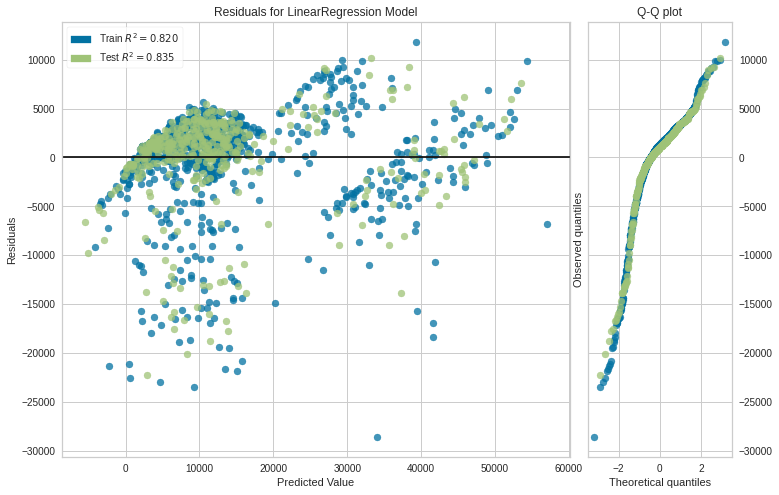

In [35]:
plt.figure(figsize=(12,8));
viz = residuals_plot(lr2, X_train2, y_train2, X_test2, y_test2, is_fitted=True, qqplot=True, hist=False);

Nuevo modelo de regresión lineal es más apropiado para los datos, los puntos están dispersos aleatoriamente alrededor del eje horizontal.

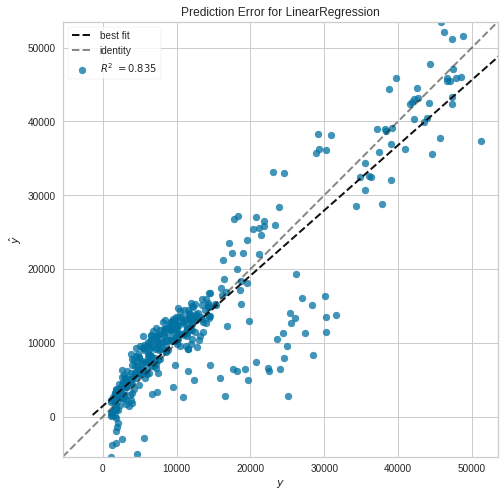

In [36]:
plt.figure(figsize=(8,8))
visualizer = prediction_error(lr2, X_test2, y_test2, is_fitted=True)

El R² alzanca ~83.5%, es decir la variablitat objetivo explica el modelo satisfactiblemente.

##Regresión LASSO

In [37]:
lr2 = LinearRegression().fit(X_train2,y_train2);

folds_r2 = cross_val_score(lr2, X_train2,y_train2, cv=5, scoring='r2')
lr_r2 = np.mean(folds_r2) 

In [38]:
lambdas = [1e-4,1e-3,1e-2,0.1, 0.5,1,5,10,50,100]

lasso_cv =LassoCV(alphas=lambdas,cv=5).fit(X_train2,y_train2)

lasso =  np.mean(cross_val_score(lasso_cv, X_train2,y_train2))

print('Best lambda:', lasso_cv.alpha_, 'R2 score:',lasso)

Best lambda: 10.0 R2 score: 0.8237290508083195


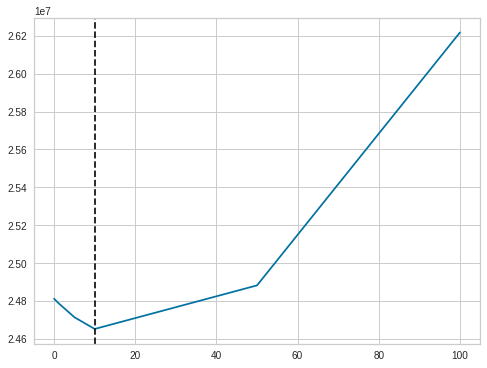

In [39]:
plt.figure(figsize=(8,6))
vis = AlphaSelection(LassoCV(alphas=lambdas));
vis.fit(X_train2, y_train2);

In [40]:
results = pd.DataFrame({'lr':lr_r2, 'lasso_cv':lasso}, index = ['CV R2'])

results.loc['Train R2', :] = [r2_score(y_train2,lr2.predict(X_train2)), r2_score(y_train2,lasso_cv.predict(X_train2))]
results.loc['lambda','lr'] = 0

results.loc['lambda','lasso_cv'] = lasso_cv.alpha_

results

,lr,lasso_cv
CV R2,0.776021,0.823729
Train R2,0.819939,0.842458
lambda,0.000000,10.000000


En la tabla de comparación que tenemos arriba, el R cuadrádo tanto calculado mediante el conjunt de datos de entrenamiento como mediante la validación cruzada ambos sale mejor resultados el modelo LASSO.

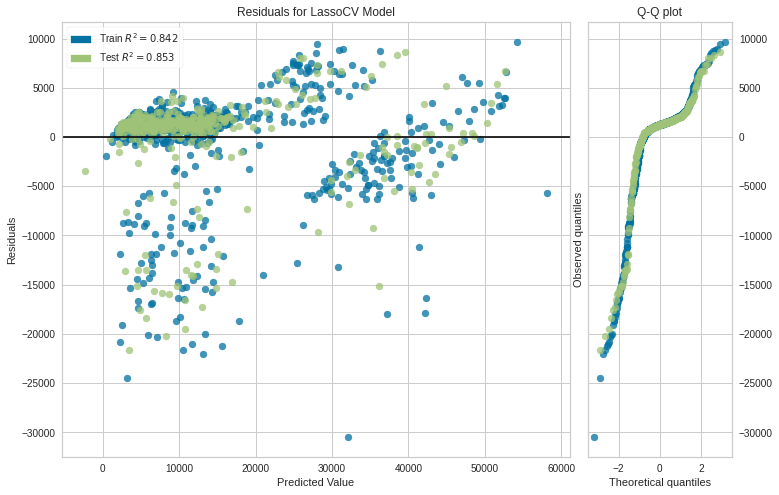

In [41]:
plt.figure(figsize=(12,8));
viz = residuals_plot(lasso_cv, X_train2, y_train2, X_test2, y_test2, is_fitted=True, qqplot=True, hist=False);

Podemos ver la representación de residuos es bastante indiferente al modelo de regresión lineal, mejorando unas décimas de R².

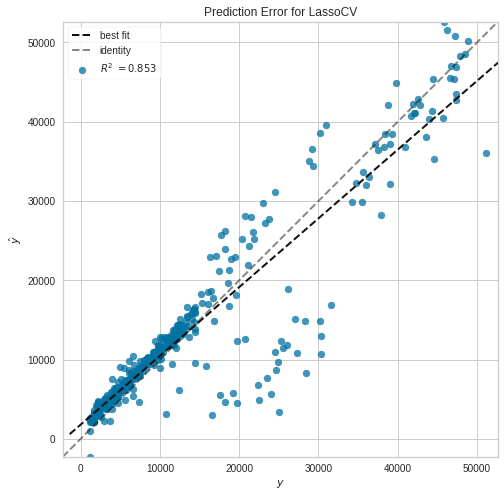

In [42]:
plt.figure(figsize=(8,8))
visualizer = prediction_error(lasso_cv, X_test2, y_test2, is_fitted=True)

El R² alzanca ~85,3%, la variablitat objetivo explica el modelo satisfactiblemente.